In this notebook we describe the code use to produce the baseline. 

# Data and Libraries

In [ ]:
import pandas as pd
import pickle
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import re 
import collections
import itertools
import pickle
import warnings
from tqdm import tqdm
import plotly.offline as pof
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
import sklearn.metrics as smet

import re
import unicodedata
import nltk
from string import digits
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sb
from scipy import sparse
sb.set_style("whitegrid")

import sklearn.model_selection as sms

DATA_PATH = "defi-ia"
train_df = pd.read_json(DATA_PATH+"/train.json")
test_df = pd.read_json(DATA_PATH+"/test.json")
train_label = pd.read_csv(DATA_PATH+"/train_label.csv")
label_metier= pd.read_csv(DATA_PATH+"/categories_string.csv")
print("Taille des données train_df : %d lignes" %train_df.shape[0])
print("Taille des données train_label : %d lignes" %train_label.shape[0])
print("Taille des données test : %d lignes" %test_df.shape[0])
print("Taille des labels métiers : %d lignes" %label_metier.shape[0])

Taille des données train_df : 217197 lignes
Taille des données train_label : 217197 lignes
Taille des données test : 54300 lignes
Taille des labels métiers : 28 lignes


In [ ]:
label_metier.rename(columns={"1" : "Category"}, inplace=True)

In [ ]:
label_metier.head(5)

,0,Category
0,pastor,0
1,model,1
2,yoga_teacher,2
3,teacher,3
4,personal_trainer,4


In [ ]:
train_df.head(5)

,Id,description,gender
0,0,She is also a Ronald D. Asmus Policy Entrepre...,F
1,1,He is a member of the AICPA and WICPA. Brent ...,M
2,2,Dr. Aster has held teaching and research posi...,M
4,3,He runs a boutique design studio attending cl...,M
5,4,"He focuses on cloud security, identity and ac...",M


In [ ]:
train_df

,Id,description,gender
0,0,She is also a Ronald D. Asmus Policy Entrepre...,F
1,1,He is a member of the AICPA and WICPA. Brent ...,M
2,2,Dr. Aster has held teaching and research posi...,M
4,3,He runs a boutique design studio attending cl...,M
5,4,"He focuses on cloud security, identity and ac...",M
...,...,...,...
271492,217192,A member of the UWA Cultural Collections Boar...,M
271493,217193,Kelly has worked globally leading teams of co...,F
271494,217194,He's the lead author of a recent study that f...,M
271495,217195,She specializes in the theoretical and pedago...,F


In [ ]:
test_df

,Id,description,gender
3,0,She currently works on CNN’s newest primetime...,F
6,1,Lavalette’s photographs have been shown widel...,M
11,2,Along with his academic and professional deve...,M
17,3,She obtained her Ph.D. in Islamic Studies at ...,F
18,4,She studies issues of women and Islam and has...,F
...,...,...,...
271476,54295,"Prior to that, she worked as a Research Staff...",F
271477,54296,The group’s antics began when they switched t...,M
271482,54297,"Formerly, she was the Coordinator for Music E...",F
271485,54298,She started her law practice at Morris Mannin...,F


In [ ]:
train_label.head(5)

,Id,Category
0,0,19
1,1,9
2,2,19
3,3,24
4,4,24


In [ ]:
label_string=pd.merge(train_label,label_metier, on=['Category'])

On a merge les deux dataframe afin de mieux pouvoir visualiser les métiers en surreprésentation.

In [ ]:
data_count = label_string["0"].value_counts()
all_string=pd.merge(label_string,train_df, on=['Id'])
femme = all_string[ all_string['gender'] == "F" ]
homme = all_string[ all_string['gender'] == "M" ]
femme =femme.rename(columns={'Id': 'CountF'})
femme =femme.rename(columns={'0': 'Metier'})

del femme['description']
del femme['Category']
del femme['gender']

femme2 = femme.groupby(['Metier']).count()

homme =homme.rename(columns={'Id': 'CountH'})
homme =homme.rename(columns={'0': 'Metier'})

del homme['description']
del homme['Category']
del homme['gender']

homme2 = homme.groupby(['Metier']).count()
compare_h_f=pd.merge(homme2,femme2, on=['Metier'])
compare_h_f['Metier2'] = compare_h_f.index.tolist()

In [ ]:
compare_h_f

,CountH,CountF,Metier2
Metier,,,
accountant,1992,1129,accountant
architect,4527,1314,architect
attorney,11714,7106,attorney
chiropractor,1015,391,chiropractor
comedian,1294,345,comedian
composer,2842,553,composer
dentist,3555,1895,dentist
dietitian,168,2120,dietitian
dj,706,125,dj


On peut remarquer une grande disparité dans la représentation des catégories.

In [ ]:
desc_metier=pd.merge(label_string,train_df, on=['Id'])
desc_metier

,Id,Category,0,description,gender
0,0,19,professor,She is also a Ronald D. Asmus Policy Entrepre...,F
1,2,19,professor,Dr. Aster has held teaching and research posi...,M
2,10,19,professor,"An elder in the United Methodist Church, she ...",F
3,11,19,professor,She has written numerous scholarly articles o...,F
4,12,19,professor,"He is an expert on black Pentecostalism, an o...",M
...,...,...,...,...,...
217192,216325,23,paralegal,She prides on empathizing and adhering to str...,F
217193,216796,23,paralegal,Heather began her legal career in 1993 specia...,F
217194,216797,23,paralegal,Janet began her career in the legal industry ...,F
217195,217016,23,paralegal,As the Senior Paralegal she works with client...,F


# Cleaning

The only cleaning transformation applied here is that we `lower` the data so that all words are lower case. 
Hence `research`and `Research` will be considered as similar word.

You might want to look at other cleaning step such that removing stopwords, stemming words, etc.

In [ ]:
i = 47
description = train_df.description.values[i]
print("Original Description : " + description)

Original Description :  Dr. Harr is a licensed clinical social worker with several years of practice and teaching experience both in the United States and internationally. She has conducted research and published in the areas of family, mental health, compassion fatigue, and interdisciplinary relationships.


In [ ]:
for i in range(51,100) :
    description = train_df.description.values[i]
    print(description)

 Dr Reynolds owned a 4 doctor, 42 employee practice for 32 years before selling it and moving into academia. Dr. Reynolds received his dental degree from the University of Detroit and his M.S.B.A, in Medical and Dental Practice Administration, from Madonna University, in Livonia, Michigan.
 His specialist interests include bariatric surgery (weight loss surgery, including gastric band and gastric balloon), advanced laparoscopic (keyhole) surgery and cancer surgery.Current Memberships:Association of Surgeons of Great Britain and Ireland Association of Upper GI Surgeons Assocation of Endoscopic Surgeons British Obesity Surgery Society Registered Member of:General Medical Council (GMC No 3316177) • Association of Surgeons of Great Britain and Ireland • Association of Upper Gastrointestinal Surgeons • Association of Laparoscopic Surgeons • British Obesity Surgery Society • International Federation for the Surgery of Obesity • European Association of Endoscopic Surgery • South West Gastroen

In [ ]:
digits_list = digits
class CleanText:

    def __init__(self):

        english_stopwords = nltk.corpus.stopwords.words('english')
        new_words=('interest','interests', 'include','includes', 'including', 'received', 'new', 'work', 'works', 
                 'working', 'worked', 'current', 'currently')
        for i in new_words:
               english_stopwords.append(i)
        self.stopwords = [self.remove_accent(sw) for sw in english_stopwords]
        self.stemmer = nltk.stem.SnowballStemmer('english')
        print(self.stopwords)

    @staticmethod
    def remove_html_code(txt):
        txt = BeautifulSoup(txt, "html.parser", from_encoding='utf-8').get_text()
        return txt

    @staticmethod
    def convert_text_to_lower_case(txt):
        return txt.lower()

    @staticmethod
    def remove_accent(txt):
        return unicodedata.normalize('NFD', txt).encode('ascii', 'ignore').decode("utf-8")

    @staticmethod
    def remove_non_letters(txt):
        return re.sub('[^a-z_]', ' ', txt)

    def remove_stopwords(self, txt):
        return [w for w in txt.split() if (w not in self.stopwords)]

    def get_stem(self, tokens):
        return [self.stemmer.stem(token) for token in tokens]

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
c=CleanText()
def apply_all_transformation(description):
    description = c.remove_html_code(description)
    description = c.convert_text_to_lower_case(description)
    description = c.remove_accent(description)
    description = c.remove_non_letters(description)
    #tokens = c.get_stem(description)
    #tokens = c.remove_stopwords(tokens) 
    tokens = c.remove_stopwords(description)
    tokens = c.get_stem(tokens)
    return tokens

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def clean_df_column(df,column_name, clean_column_name) :
    df[clean_column_name]=[" ".join(apply_all_transformation(x)) for x in tqdm(df[column_name].values)]

In [ ]:
clean_df_column(train_df, "description", "description_cleaned")
train_df[["description", "description_cleaned"]]

100%|██████████| 217197/217197 [02:42<00:00, 1334.22it/s]


,description,description_cleaned
0,She is also a Ronald D. Asmus Policy Entrepre...,also ronald asmus polici entrepreneur fellow g...
1,He is a member of the AICPA and WICPA. Brent ...,member aicpa wicpa brent graduat univers wisco...
2,Dr. Aster has held teaching and research posi...,dr aster held teach research posit ben gurion ...
4,He runs a boutique design studio attending cl...,run boutiqu design studio attend client unit s...
5,"He focuses on cloud security, identity and ac...",focus cloud secur ident access manag mobil sec...
...,...,...
271492,A member of the UWA Cultural Collections Boar...,member uwa cultur collect board gari chief cur...
271493,Kelly has worked globally leading teams of co...,kelli global lead team consult year kelli hold...
271494,He's the lead author of a recent study that f...,lead author recent studi found hospit complic ...
271495,She specializes in the theoretical and pedago...,special theoret pedagog foundat bilingu educ f...


In [ ]:
clean_df_column(test_df, "description", "description_cleaned")
test_df[["description", "description_cleaned"]]

100%|██████████| 54300/54300 [00:40<00:00, 1334.23it/s]


,description,description_cleaned
3,She currently works on CNN’s newest primetime...,current cnns newest primetim show parker spitz...
6,Lavalette’s photographs have been shown widel...,lavalett photograph shown wide editori publish...
11,Along with his academic and professional deve...,along academ profession develop gabriel live s...
17,She obtained her Ph.D. in Islamic Studies at ...,obtain ph islam studi duke univers special isl...
18,She studies issues of women and Islam and has...,studi issu women islam written polygami among ...
...,...,...
271476,"Prior to that, she worked as a Research Staff...",prior research staff member ibm j watson resea...
271477,The group’s antics began when they switched t...,group antic began switch voic box talk barbi g...
271482,"Formerly, she was the Coordinator for Music E...",former coordin music educ univers wisconsin st...
271485,She started her law practice at Morris Mannin...,start law practic morri man martin real estat ...


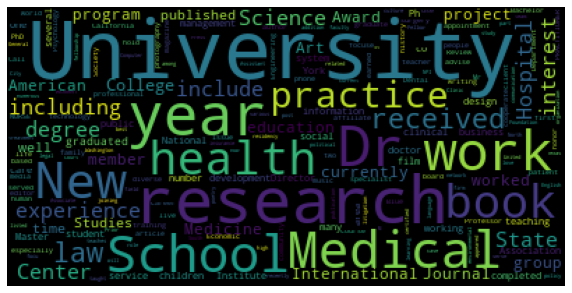

In [ ]:
from wordcloud import WordCloud
all_descr = " ".join(train_df.description.values)
wordcloud_word = WordCloud(background_color="black", collocations=False).generate_from_text(all_descr)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

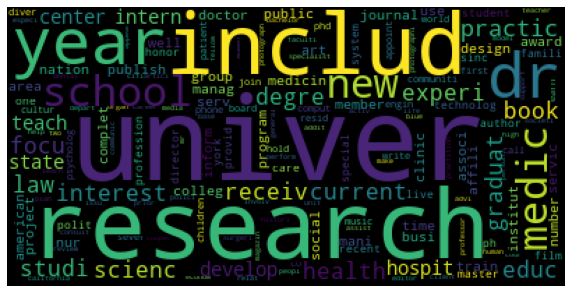

In [ ]:
all_descr_clean_stem = " ".join(train_df.description_cleaned.values)
wordcloud_word = WordCloud(background_color="black", collocations=False).generate_from_text(all_descr_clean_stem)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

# Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
transformer = TfidfVectorizer().fit(train_df["description_cleaned"].values)
print("NB features: %d" %(len(transformer.vocabulary_)))
X_train = transformer.transform(train_df["description_cleaned"].values)
X_test = transformer.transform(test_df["description_cleaned"].values)
X_train

NB features: 175824


<217197x175824 sparse matrix of type '<class 'numpy.float64'>'
	with 6776112 stored elements in Compressed Sparse Row format>

# Learning

### Ramdom Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [ ]:
Y_train = train_label.Category.values

In [ ]:
Y_train2 = Y_train[:10000] 
X_train2 = X_train[:10000] 

In [ ]:
model= RandomForestClassifier()
score = 'accuracy'
cv=4
param_grid = {'n_estimators':[100, 120, 140], 'criterion':['gini', 'entropy']}
clf = GridSearchCV(
      model,
      param_grid, 
      cv=cv,
      scoring=score   
)
clf.fit(X_train, Y_train)
print("Meilleur(s) hyperparametre(s) sur le jeu d'entrainement:")
print(clf.best_params_)
print("Avec une accuracy maximale de")
print(clf.best_score_)

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

- Prediction

In [ ]:
predictions = model.predict(X_test)
predictions

array([19, 20, 19, ..., 19, 26, 15])

In [ ]:
predictionsRF=predictions

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model= LogisticRegression()
score = 'accuracy'
cv=4
param_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 'C':[0.8,1,1.2]}
clf = GridSearchCV(
      model,
      param_grid, 
      cv=cv,
      scoring=score   
)
clf.fit(X_train, Y_train)
print("Meilleur(s) hyperparametre(s) sur le jeu d'entrainement:")
print(clf.best_params_)
print("Avec une accuracy maximale de")
print(clf.best_score_)

Meilleur(s) hyperparametre(s) sur le jeu d'entrainement:
{'C': 1, 'penalty': 'l2'}
Avec une accuracy maximale de
0.7851076312262804


In [ ]:
model = LogisticRegression(C=1, penalty='l2')
model.fit(X_train, Y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predictions = model.predict(X_test)
predictions

array([ 6, 20, 22, ..., 25, 26, 15])

In [ ]:
accuracy_RL=accuracy_score(y_true, predictions)
accuracy_RL

### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
model= MLPClassifier()
score = 'accuracy'
cv=4
param_grid = {'hidden_layer_sizes':[(100,), (200,)], 'activation':['identity', 'logistic', 'tanh', 'relu']}
clf = GridSearchCV(
      model,
      param_grid, 
      cv=cv,
      scoring=score   
)
clf.fit(X_train2, Y_train2)
print("Meilleur(s) hyperparametre(s) sur le jeu d'entrainement:")
print(clf.best_params_)
print("Avec une accuracy maximale de")
print(clf.best_score_)

In [ ]:
model = MLPClassifier()
model.fit(X_train, Y_train)

In [ ]:
predictions = model.predict(X_test)
predictions

In [ ]:
accuracy_ML=accuracy_score(y_true, predictions)
accuracy_ML

# File Generation

In [ ]:
test_df["Category"] = predictions
baseline_file = test_df[["Id","Category"]]
baseline_file.to_csv("RF.csv", index=False)

In [ ]:
baseline_file.head(5)

,Id,Category
3,0,6
6,1,20
11,2,22
17,3,19
18,4,19


In [ ]:
file_metier=pd.merge(file,label_metier, on=['Category'])

NameError: ignored

In [ ]:
print(file_metier.head(20))

In [ ]:
print(test_df)